In [8]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

from src.utils.data_utils import MMNist
from src.utils.gan_trainer import ModelTrainer

from src.models.vaegan import VAEGAN_Gen, VAEGAN_Disc, Initializer

import numpy as np
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
TEST_MODEL_PATH = os.path.join(os.getcwd(), 'src', 'experiments', 'vaegan-mmnist')
IMAGE_SZ = (64, 64)
NUM_WORKERS = 4
IMG_BATCH_SZ = 128
GIF_BATCH_SZ = 64
TRANSFORMS = transforms.Compose([transforms.Resize(IMAGE_SZ), transforms.ToTensor()])
DISP_LIM = 8

In [10]:
USE_GPU = True

dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using device:', device)
print('Using type:', dtype)

Using device: cuda
Using type: torch.float32


In [11]:
MAX_FRAMES = 10
LEN_LIM = 160000

DATASET_ROOT = '/home/deepdeepfakes/cs231n-project/src/datasets/MMNIST'

train_set = MMNist(f'{DATASET_ROOT}/train_set.npz', len_lim=LEN_LIM,
                   transform=transforms.Compose([
#                         transforms.Resize(IMAGE_SZ),                   
                        transforms.ToTensor()
                    ]),
)

val_set = MMNist(f'{DATASET_ROOT}/val_set.npz', len_lim=LEN_LIM,
                   transform=transforms.Compose([
#                         transforms.Resize(IMAGEw_SZ), 
                        transforms.ToTensor()
                         
                    ]),
)


FileNotFoundError: [Errno 2] No such file or directory: '/home/deepdeepfakes/cs231n-project/src/datasets/MMNIST/train_set.npz'

In [ ]:
BATCH_SZ = 128


train_loader = DataLoader(train_set, batch_size=BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_set, batch_size=BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)

print(len(train_set), len(val_set)) #, len(test_set))

z = val_set[0]
print(torch.max(z))
# torch.nonzero(z)
# print(z[1307])
# print(z.to(dtype=dtype)[1307])

In [ ]:

def deprocess(img):
    transform = transforms.Compose([
        transforms.Lambda(rescale),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled



In [ ]:
import matplotlib.pyplot as plt


def gif_show(gif):
    npimg = gif.numpy()
    out = np.transpose(npimg, (1, 2, 0))
    plt.figure(figsize=(20,40))
    plt.imshow(out)

def sample(model, seed_frame, gif_length=10):
    curr_h = model.init_hidden(BATCH_SZ)
    curr_x = seed_frame.to(device=device, dtype=dtype)
    model.eval()
    ret = [seed_frame]
    for i in range(gif_length - 1):
        y, curr_h = model(curr_x, curr_h)
        curr_x = y
        ret.append(y.to(device = torch.device('cpu')))
    return torch.stack(ret).transpose(0, 1)
    
def img_test_autoenc(model, loader):
    model.eval()
    dataiter = iter(loader)
    x = dataiter.next()
#     x = x[0]
    print (x.shape)
    x = torch.tensor(x)
    x = x.to(device=device, dtype=dtype)
    y, mu, logvar = model(x)
    x = x.to(torch.device('cpu')).detach()
    y = torch.clamp(y.to(torch.device('cpu')).detach(), 0, 1)
    imgs = torch.cat([x[:DISP_LIM], y[:DISP_LIM]])
    gif_show(torchvision.utils.make_grid(imgs))
    
def gif_test_autoenc(model, loader):
    model.eval()
    dataiter = iter(loader)
    x = dataiter.next()
    x = x[:, 0, :, :, :]
    x = x.to(device=device, dtype=dtype)
    y, mu, logvar = model(x)
    x = x.to(torch.device('cpu')).detach()
    y = torch.clamp(y.to(torch.device('cpu')).detach(), 0, 1)
    imgs = torch.cat([x[:DISP_LIM], y[:DISP_LIM]])
    gif_show(torchvision.utils.make_grid(imgs))
    

In [ ]:

def train_gan(gen_model, disc_model,  g_optimizer, d_optimizer, loader, epochs=4, print_every=100, save_every=100, verbose=True):
    
    criterion = nn.BCEWithLogitsLoss(size_average=True)
    gan_reg = 1e-4 
    kl_reg = 1e-8
    disc_err_fake_reg = 1
    
    for e in range(epochs):
        for t, inp in enumerate(loader):

            gen_model.train()
            disc_model.train()            
            
            d_optimizer.zero_grad()
            
#             x = inp[:, 0]
            x = inp
            x = x.to(device=device, dtype=dtype)
                        
            recon_x, mu, logvar = gen_model(x)
            

            rec_noise = gen_model.decoder(torch.randn(x.shape[0], 95, device=device))  # TODO: magic numbers
            
            logits_real = disc_model(x).squeeze()
            logits_fake = disc_model(recon_x).squeeze()
            logits_err = disc_model(rec_noise).squeeze()
            


            all_ones = torch.ones(logits_real.shape[0], device=device)
            all_zeros = torch.zeros(logits_real.shape[0], device=device)
                
            # train discriminator
            disc_err_real = criterion(logits_real, all_ones)
            disc_err_fake = disc_err_fake_reg * criterion(logits_fake, all_zeros)
            disc_err_noise = criterion(logits_err, all_zeros)     # random noise
            
            disc_loss = disc_err_real + disc_err_fake


            disc_loss.backward()
            d_optimizer.step()

#             disc_loss = 0
            
            
            
            g_optimizer.zero_grad()
            recon_x, mu, logvar = gen_model(x)
            
            gen_logits_fake = disc_model(recon_x)
            gen_logits_fake = gen_logits_fake.squeeze()

            gen_loss_gan = gan_reg * criterion(gen_logits_fake, all_ones)

#             gen_loss_gan = 0 
            


            mse_loss = nn.MSELoss(size_average=True)
            MSE = mse_loss(recon_x, x)            
            
            KLD = kl_reg * (-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()))
            
#             print(MSE.item(), KLD.item(), GAN_LAMBDA*gen_loss_gan.item())
            gen_loss = MSE + KLD + gen_loss_gan
            
            
            gen_loss.backward()
            g_optimizer.step()

            if verbose and t % print_every == 0:
                print(f'Epoch [{e}] ({t}/{len(loader)}), \t gen_loss  = {gen_loss:.4f} \t(recr: {MSE:.6f}, gan: {gen_loss_gan:.6f}), \n\t\t\t ' 
                      +  f'disc_loss = {disc_loss:.4f} \t(real: {disc_err_real:.6f}, fake: {disc_err_fake:.6f})\n')



            if t % save_every == 0:
                pass
#                 self.save_data()
        if verbose:
            print (f'Epoch [{e}] done')


In [ ]:
NUM_CHANNELS = 1
INPUT_SIZE = IMAGE_SZ[0] * IMAGE_SZ[1] * NUM_CHANNELS

LATENT_SIZE = 95

gen = VAEGAN_Gen(latent_size=LATENT_SIZE, device=device, num_channels=NUM_CHANNELS)
disc = VAEGAN_Disc(latent_size=LATENT_SIZE, device=device, num_channels=NUM_CHANNELS)

Initializer.initialize(model=gen, initialization=init.xavier_uniform_, gain=init.calculate_gain('relu'))
Initializer.initialize(model=disc, initialization=init.xavier_uniform_, gain=init.calculate_gain('relu'))

g_optimizer = optim.Adam(gen.parameters(), lr=5e-4)
d_optimizer = optim.Adam(disc.parameters(), lr=5e-4)


In [74]:

# g_optimizer = optim.Adam(gen.parameters(), lr=1e-5)
d_optimizer = optim.Adam(disc.parameters(), lr=1e-7)

In [89]:
try:
    print('Starting training...')
    train_gan(gen, disc, g_optimizer, d_optimizer, train_loader, epochs=2, print_every=100)

except KeyboardInterrupt:
    print("Force saving")
#     trainer.save_data(force_save=True)

Starting training...
Epoch [0] (0/1250), 	 gen_loss  = 0.0087 	(recr: 0.008190, gan: 0.000039), 
			 disc_loss = 1.8123 	(real: 0.396436, fake: 1.415815)

Epoch [0] (100/1250), 	 gen_loss  = 0.0086 	(recr: 0.008137, gan: 0.000042), 
			 disc_loss = 1.8294 	(real: 0.390578, fake: 1.438800)

Epoch [0] (200/1250), 	 gen_loss  = 0.0084 	(recr: 0.007891, gan: 0.000039), 
			 disc_loss = 1.7983 	(real: 0.389488, fake: 1.408799)

Epoch [0] (300/1250), 	 gen_loss  = 0.0087 	(recr: 0.008228, gan: 0.000039), 
			 disc_loss = 1.8273 	(real: 0.418055, fake: 1.409256)

Epoch [0] (400/1250), 	 gen_loss  = 0.0083 	(recr: 0.007837, gan: 0.000041), 
			 disc_loss = 1.8074 	(real: 0.409857, fake: 1.397523)

Epoch [0] (500/1250), 	 gen_loss  = 0.0083 	(recr: 0.007773, gan: 0.000039), 
			 disc_loss = 1.8068 	(real: 0.401544, fake: 1.405298)

Epoch [0] (600/1250), 	 gen_loss  = 0.0087 	(recr: 0.008176, gan: 0.000041), 
			 disc_loss = 1.7896 	(real: 0.397674, fake: 1.391950)

Epoch [0] (700/1250), 	 gen_l

In [2]:
img_test_autoenc(gen, train_loader)

NameError: name 'img_test_autoenc' is not defined

torch.Size([128, 1, 64, 64])


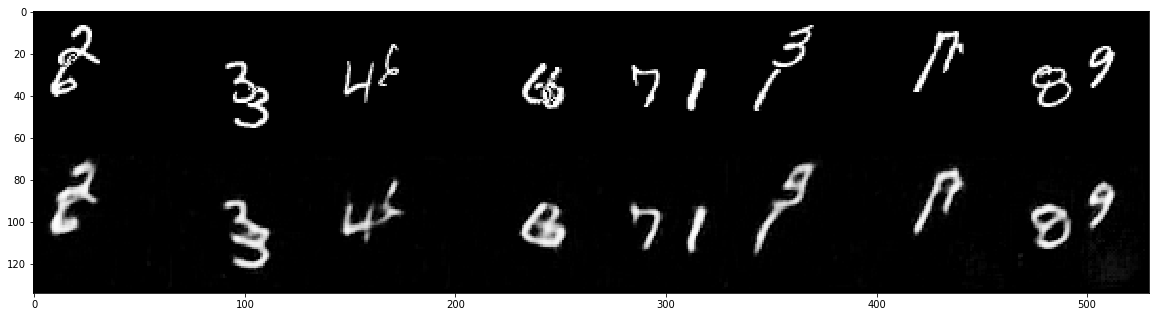

In [91]:
img_test_autoenc(gen, val_loader)

In [92]:
# save_path = '/home/deepdeepfakes/cs231n-project/src/backups/vaegan-mmnist/vaegan-best2'

# gan_state = {
#     'gen_state_dict': gen.state_dict(),
#     'disc_state_dict': disc.state_dict(),
#     'config': 'gan_reg = 1e-4, kl_reg = 1e-8, disc_err_fake_reg = 1'    
# }



torch.save(gan_state, save_path)


# state = torch.load(save_path)

# gen.load_state_dict(state['gen_state_dict'])

## Varying Latent Space

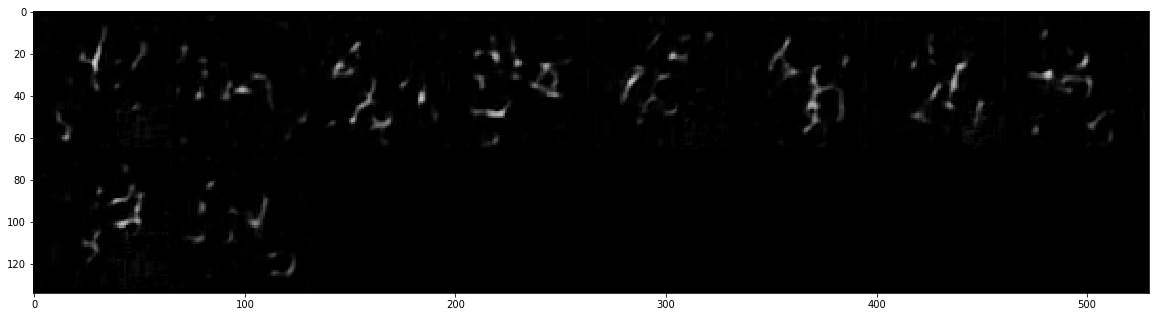

In [93]:

def gen_image(model):
    z = torch.randn((10, 95), device=device)
    y = model.decoder(z)
    y = torch.clamp(y.to(torch.device('cpu')).detach(), 0, 1)
    gif_show(torchvision.utils.make_grid(y))
    

gen_image(gen)

torch.Size([128, 95])


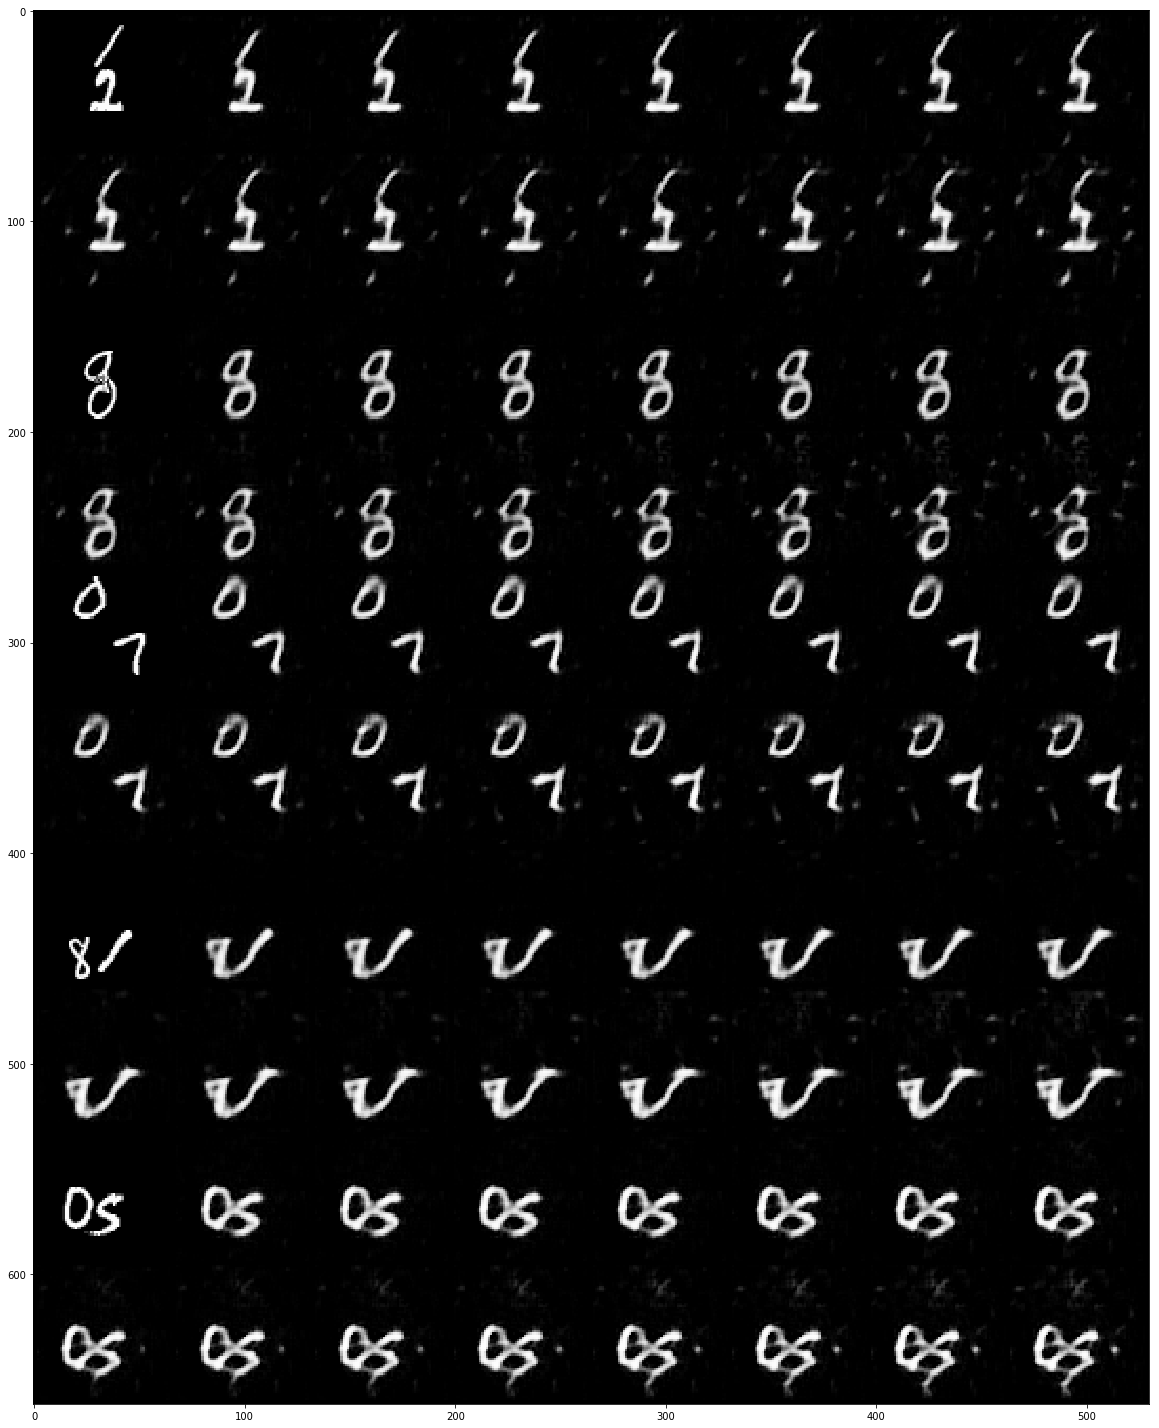

In [94]:
def vary_latent(init_z, step, length, dim, model, orig_img):
    print(init_z.shape)
    BATCH_IDX = 15
    BATCH_LIM = 5
    orig_img = orig_img.to(torch.device('cpu')).detach()

    ret = []
    curr_z = init_z.clone()
    curr_z = curr_z.to(device=device)
    
#     curr_z[dim] -= step*(length // 2)
    
    model.eval()
    for batch in range(BATCH_LIM):
        curr_z = init_z.clone()
        ret.append(orig_img[batch]) 
        for i in range(length):
            curr_z[:, dim] += step
            y = model.decoder(curr_z)
            y = torch.clamp(y.to(torch.device('cpu')).detach(), 0, 1)
            ret.append(y[batch])
    
    gif_show(torchvision.utils.make_grid(torch.stack(ret)))
        
        
    

def get_latent_z(model, x):
    enc_y = model.encoder(x)
    mu, logvar = model.fc_mu(enc_y), model.fc_logvar(enc_y)
    return model.sample_latent(mu, logvar)


def sample_forward(model, z):
    return model.decoder(z)


def test_varying(model, loader):
    model.eval()
    dataiter = iter(loader)
    x = dataiter.next()    
#     x = x[0]
    x = x.to(device=device, dtype=dtype)

    z = get_latent_z(model, x)
    vary_latent(z, 1.0, 15, 0, model, x)
    
test_varying(gen, train_loader)

tensor(1., device='cuda:0') tensor(0., device='cuda:0')


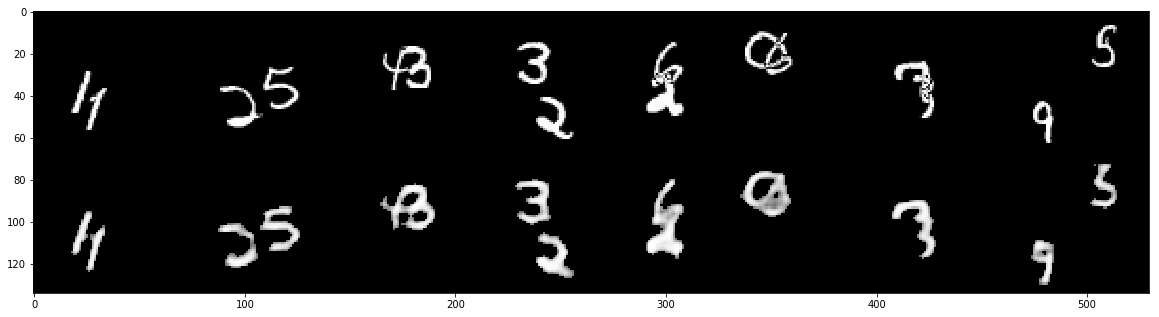

In [95]:

plt.figure(figsize=(20,40))

    
DISP_LIM = 8

def test_autoenc2(model, loader):
    model.eval()
    dataiter = iter(loader)
    
    x = dataiter.next()
#     x = x[0]

    


    x = x.to(device=device, dtype=dtype)


    
    y, mu, logvar = model(x)
    y = deprocess(y)
    
    print(torch.max(y), torch.min(y))
    
    x = x.to(torch.device('cpu')).detach()
    
#     y = torch.clamp(y.to(torch.device('cpu'), dtype=torch.uint8).detach(), 0, 255)
    y = y.to(torch.device('cpu')).detach()
    y[y < 0.45] = 0

    
    imgs = torch.cat([x[:DISP_LIM], y[:DISP_LIM]])
    
    gif_show(torchvision.utils.make_grid(imgs)) #, save_file='img/train_test_out.png')
    
    
    
    
    

test_autoenc2(gen, val_loader)